In [1]:
%load_ext autoreload
%autoreload 2

import sklearn.metrics as metrics
from utils.temperature_scaling import ModelWithTemperature
from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.mnist
import models.resnet_dropout
import models.resnet

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
transforms_normalized = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor()
])


dataset = torchvision.datasets.VOCSegmentation(
    root="VOC", download=True, image_set="val", transform=transforms_normalized, target_transform=target_transforms)
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=64,
                                          shuffle=False)

Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC


In [4]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "dining table",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

def decode_segmap(image, nc=22):
    label_colors = np.array([(0, 0, 0),  # 0=background
                             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                             (128, 0, 0), (0, 128, 0), (128, 128,
                                                        0), (0, 0, 128), (128, 0, 128),
                             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                             (0, 128, 128), (128, 128, 128), (64,
                                                              0, 0), (192, 0, 0), (64, 128, 0),
                             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                             (192, 128, 0), (64, 0, 128), (192, 0,
                                                           128), (64, 128, 128), (192, 128, 128),
                             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                             (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128), (128, 128, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [5]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(
    pretrained=True)
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),

In [6]:
from tqdm import tqdm
def run_validation(model, data_loader, test_progress: utils.metrics.Progress, device, mc_dropout_iters=0):
    softmax = nn.Softmax(dim=1)
    progress_bar = tqdm(data_loader)
    count = 0
    running_corrects = 0
    model = model.to(device)
    softmax = torch.nn.Softmax(dim=1)
    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        count += labels.numel()
        model.eval()
        with torch.no_grad():
            logits = model(inputs)["out"].cpu()
        probs = softmax(logits)
        max_probs, preds = torch.max(probs, 1)
        running_corrects += np.count_nonzero(preds == labels.squeeze(1))
        if mc_dropout_iters > 0:
            mc_means, mc_vars = utils.mc_dropout.mc_dropout(
                model, inputs, logits.shape[-1], T=mc_dropout_iters)
            # batch_nll = - utils.mc_dropout.compute_log_likelihood(
            #     mc_means, torch.nn.functional.one_hot(labels, num_classes=mc_means.shape[-1]), torch.sqrt(mc_vars))
            batch_nll = torch.tensor([0])
            test_progress.update_mcd(mc_means, mc_vars, batch_nll)

        test_progress.update(preds, labels, probs, logits)
        progress_bar.set_description(
            f"Avg. acc.: {100*running_corrects/count:.2f}")

    test_progress.predictions = np.concatenate(test_progress.predictions)
    test_progress.logits = np.concatenate(test_progress.logits)
    test_progress.probs = np.concatenate(test_progress.probs)
    if mc_dropout_iters > 0:
        test_progress.dropout_outputs = np.concatenate(
            test_progress.dropout_outputs)
    return test_progress

progress = run_validation(
    model, data_loader, utils.metrics.Progress(), device, mc_dropout_iters=0)

Avg. acc.: 56.57: 100%|██████████| 23/23 [00:31<00:00,  1.38s/it]


In [5]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(data_loader)

RuntimeError: CUDA out of memory. Tried to allocate 5.69 GiB (GPU 0; 7.80 GiB total capacity; 5.77 GiB already allocated; 887.19 MiB free; 5.83 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
print(progress.probs.shape)
progress.predictions.shape
progress.max_probs.shape

(1449, 21, 224, 224)


(72705024,)

In [17]:
import importlib
importlib.reload(utils.visualisations)

<module 'utils.visualisations' from '/home/jirka/uncertainty-estimations/utils/visualisations.py'>

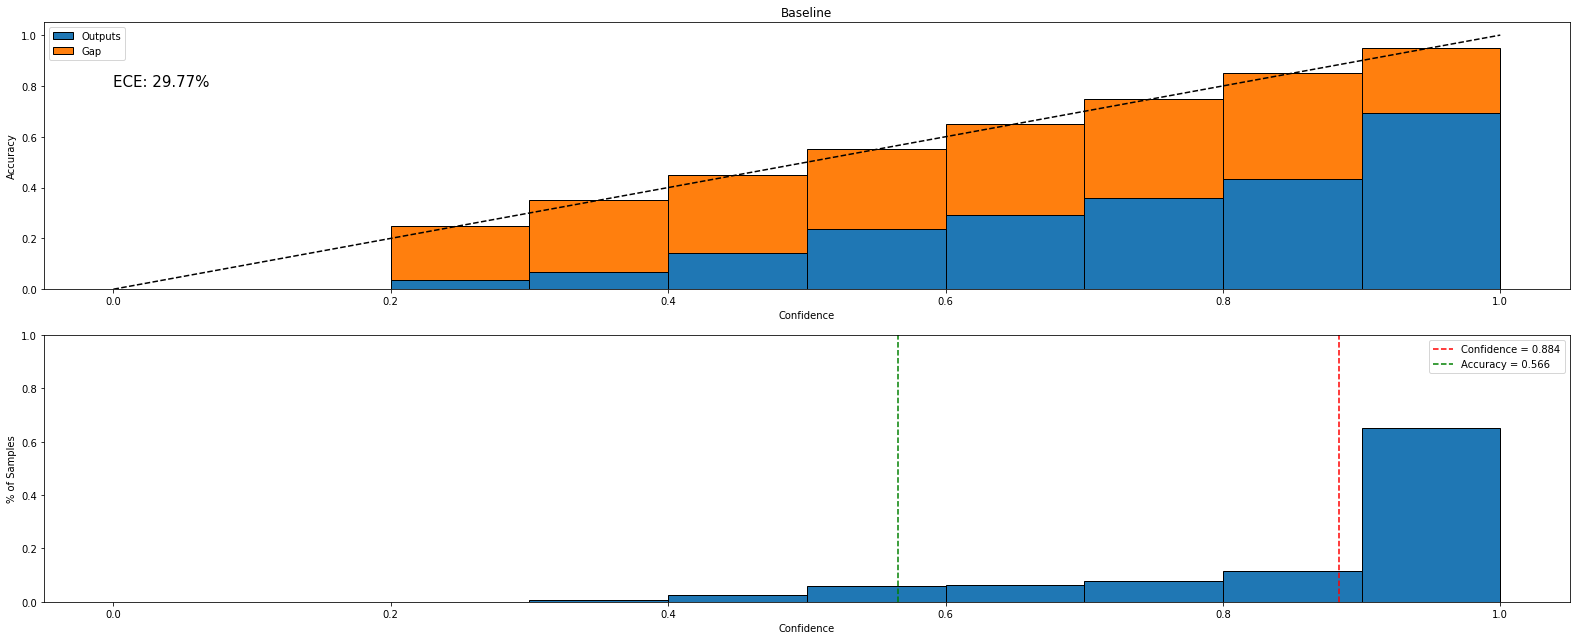

In [8]:
# nll = nn.CrossEntropyLoss()(torch.tensor(progress.logits), torch.tensor(
#     progress.labels, dtype=torch.long)).item()
# print(
#     f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
#     f"NLL: {nll:4f}"
# )

# # mc_logits = progress.dropout_logits.mean(axis=0)
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)

# utils.visualisations.samples_removed_vs_acc([
#     ("Max prob", np.argsort(progress.max_probs)),
#     ("Dropout max probs", np.argsort(dropout_max_probs))],
#     progress.labels,
#     progress.predictions,
#     progress.dropout_predictions)


utils.visualisations.calibration_graph([
        ("Baseline", progress.max_probs, np.argsort(progress.max_probs), progress.predictions.ravel()),

    ],
    progress.labels,
    )

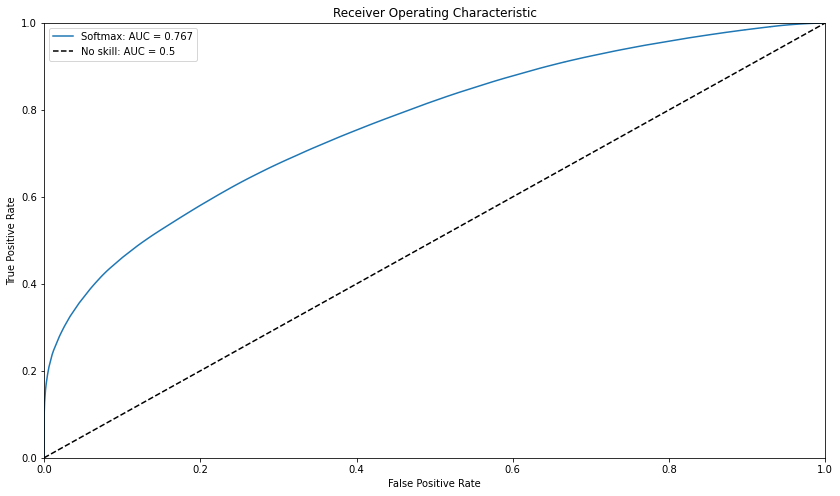

In [9]:
curves = []

correct = progress.predictions.ravel() == progress.labels.ravel()
fpr, tpr, _ = metrics.roc_curve(correct, progress.max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, progress.max_probs)
aupr = metrics.auc(recall, prec)
curves.append({
    "fpr": fpr,
    "tpr": tpr,
    "auroc": roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Softmax"
})

# correct = progress.dropout_predictions == progress.labels
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)
# fpr, tpr, _ = metrics.roc_curve(correct, dropout_max_probs)
# roc_auc = metrics.auc(fpr, tpr)

# prec, recall, _ = metrics.precision_recall_curve(correct, dropout_max_probs)
# aupr = metrics.auc(recall, prec)

# curves.append({
#     "fpr": fpr,
#     "tpr": tpr,
#     "auroc": roc_auc,
#     "prec": prec,
#     "recall": recall,
#     "aupr": aupr,
#     "label": "MC Dropout"
# })


plt.figure(figsize=(14, 8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"],
             label=f"{curve['label']}: AUC = {curve['auroc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

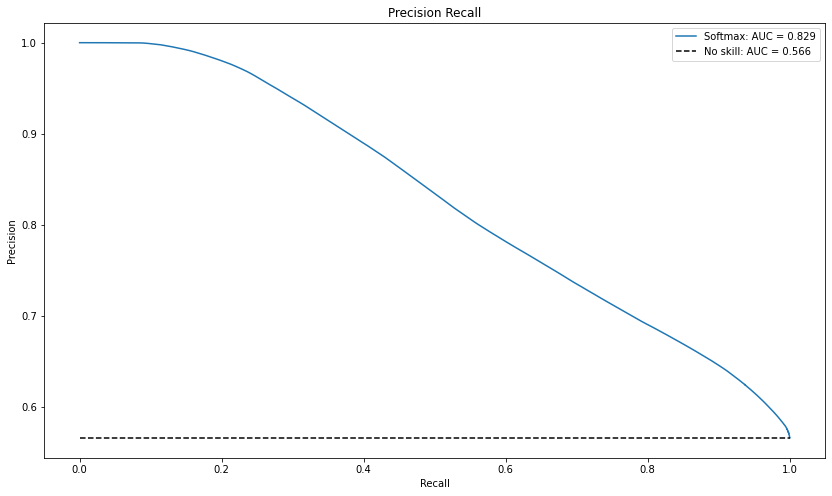

In [10]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14, 8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"],
             label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k",
         linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()